In [1]:
import os
import json
import numpy as np
import cv2 as cv  # OpenCV for image processing
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
from PIL import Image

In [13]:
# creating custom dataset for image classification task (image as whole)
''' 
Data str:
        root/
            train/
                 barrel_jellyfish/01.jpg,02.jpg,....
                 compass_jellyfish/01.jpg,02.jpg,....
                 Moon_jellyfish/01.kpg,02.jpg,....
'''
class classifydataset(Dataset):
    def __init__(self, root_dir,sub_dir,transform=None):
        self.root_dir = os.path.join(root_dir,sub_dir)
        self.transform = transform
        self.classes = ['barrel_jellyfish','blue_jellyfish','compass_jellyfish','lions_mane_jellyfish','mauve_stinger_jellyfish','Moon_jellyfish']
        self.images_paths=[]
        self.labels=[]
        for class_labels,class_name in enumerate(self.classes):
            img_dir= os.path.join(self.root_dir,class_name)
            for img_name in os.listdir(img_dir):
                img_path = os.path.join(img_dir,img_name)
                self.images_paths.append(img_path)
                self.labels.append(class_labels)
   
   
    def __len__(self):
        return len(self.images_paths)  
   
   
    def __getitem__(self,idx):
        img_paths = self.images_paths[idx]
        images = cv.imread(img_paths,cv.IMREAD_COLOR)
        images = cv.cvtColor(images,cv.COLOR_BGR2RGB)
        images = Image.fromarray(images)
        #images = Image.open(img_paths).convert("RGB")
        labels = self.labels[idx]

        if self.transform:
            images = self.transform(images)
        return images,labels

        




                




In [14]:
os.listdir(os.path.join('/Users/acer/Downloads/archive/Train_Test_Valid','Train'))

['barrel_jellyfish',
 'blue_jellyfish',
 'compass_jellyfish',
 'lions_mane_jellyfish',
 'mauve_stinger_jellyfish',
 'Moon_jellyfish']

In [15]:
trans = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
train_dataset=classifydataset(root_dir='/Users/acer/Downloads/archive/Train_Test_Valid',sub_dir='Train',transform=trans)

In [16]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)


In [17]:
'''
Example showing the working of the dataloader. Here the dataloader is coverted to an iterator by using 'iter(dataloader)'.Iterator means
object that contains countable numbers of values and can be iterated upon. The next() function retreives an item from the iterator.
When next is called on the iterator created from train_loader, it retrieves the next batch of data.

'''

images,label =next(iter(train_loader)) 
images.size()

torch.Size([32, 3, 128, 128])

In [18]:
def mean_std(loader):
    mean = 0.
    std = 0.
    total_image_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std +=images.std(2).sum(0)
        total_image_count += image_count_in_a_batch
        
    mean /= total_image_count
    std /= total_image_count
    
    return mean, std


In [19]:
mean_std(train_loader)

KeyboardInterrupt: 

In [20]:
mean = [0.4199, 0.3639, 0.2614]
std = [0.1912, 0.1745, 0.1903]


transforms_norm = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                      transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])


In [21]:
training_dataset=classifydataset(root_dir='/Users/acer/Downloads/archive/Train_Test_Valid',sub_dir='Train',transform=transforms_norm)
training_loader = DataLoader(training_dataset,batch_size=32,shuffle=True)

In [22]:
def show_images(loader):
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 4)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([0, 3, 0, 0, 4, 2, 1, 3, 4, 0, 2, 1, 3, 5, 3, 0, 0, 2, 3, 3, 5, 1, 2, 5,
        1, 2, 3, 3, 5, 5, 5, 1])


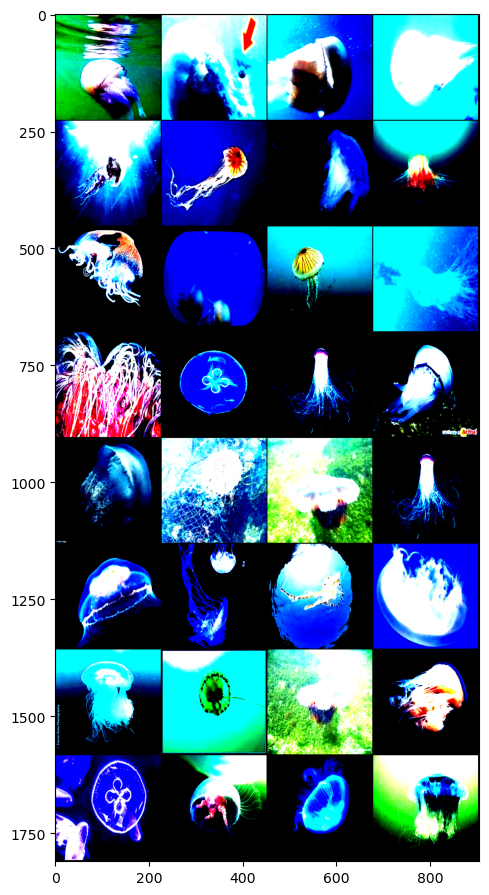

In [23]:
show_images(training_loader)

labels:  tensor([2, 1, 0, 2, 1, 3, 2, 2, 0, 4, 0, 0, 0, 4, 5, 3, 5, 3, 1, 1, 0, 5, 3, 5,
        0, 0, 0, 5, 4, 2, 2, 4])


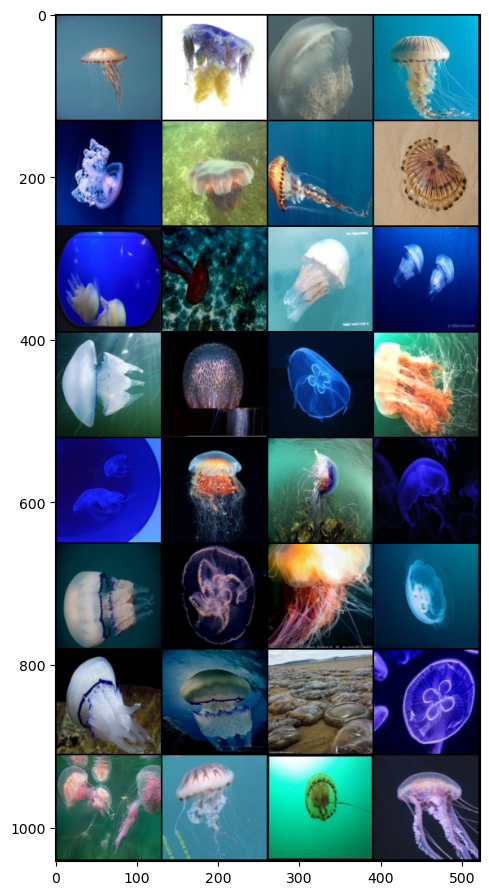

In [24]:
show_images(train_loader)

In [10]:
# setting up device CPU/GPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [11]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [20]:
# CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv = nn.Conv2d(3,32,kernel_size=5)
        self.ReLU = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(32*110*110,256)
        self.fc2 = nn.Linear(256,6)

    def forward(self,x):
        x= self.conv(x)
        x= self.ReLU(x)
        x= self.maxpool(x)
        x= self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        return x



In [21]:
#initilize the model
model = CNN().to(device)
print(model)

CNN(
  (conv): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (ReLU): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=387200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)


In [56]:
# training the model
#optimizer and loss function
my_model = '/Users/acer/Downloads/Deep learning in cv/Exercise 2/jellyfish.pth'
if os.path.exists(my_model):
    model.load_state_dict(torch.load(my_model))
    print (f'Saved model {my_model} found and loaded')
else:
    
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    num_epochs = 40
    # batch_size = 32
    #dataloader = get_data_loader(data_dir, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for i, (images, labels) in enumerate(training_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Update statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            # Print mini-batch statistics
            if (i + 1) % 10 == 0:
                mini_batch_loss = running_loss / total_samples
                mini_batch_accuracy = correct_predictions / total_samples
                print(f"Minibatch Loss: {mini_batch_loss:.4f}  Accuracy: {mini_batch_accuracy:.4f}")

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(training_loader.dataset)
        epoch_accuracy = correct_predictions / len(training_loader.dataset)

        print(f"Loss: {epoch_loss:.4f}  Accuracy: {epoch_accuracy:.4f}")
        print()
        torch.save(model.state_dict(), 'jellyfish.pth')

Saved model /Users/acer/Downloads/Deep learning in cv/Exercise 2/jellyfish.pth found and loaded


In [26]:
test_dataset=classifydataset(root_dir='/Users/acer/Downloads/archive/Train_Test_Valid',sub_dir='test',transform=transforms_norm)
test_loader = DataLoader(training_dataset,batch_size=32,shuffle=True)
 

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Set the model to evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    # Initialize variables for predictions and true labels
    predicted_labels = []
    true_labels = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate predicted labels
        _, predicted = torch.max(outputs.data, 1)
        
        # Update predicted labels and true labels
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Calculate precision, recall, F1-score, and overall accuracy
classification_rep = classification_report(true_labels, predicted_labels)
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Print the results
print("Classification Report:")
print(classification_rep)
print()
print("Confusion Matrix:")
print(confusion_mat)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       150
           4       1.00      1.00      1.00       150
           5       1.00      1.00      1.00       150

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900


Confusion Matrix:
[[150   0   0   0   0   0]
 [  0 150   0   0   0   0]
 [  0   0 150   0   0   0]
 [  0   0   0 150   0   0]
 [  0   0   0   0 150   0]
 [  0   0   0   0   0 150]]


In [46]:
# load any picture and classify it and print out the image and labels
def classification(src):
    classes = ['barrel_jellyfish','blue_jellyfish','compass_jellyfish','lions_mane_jellyfish','mauve_stinger_jellyfish','Moon_jellyfish']
    image_cv = cv.imread(src,cv.COLOR_BGR2RGB)
    preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to the input size expected by the model
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.4199, 0.3639, 0.2614], std=[0.1912, 0.1745, 0.1903])])  # Normalize with mean and std
    image = Image.fromarray(image_cv)
    image = preprocess(image)
    input_tensor = image.unsqueeze(0).to(device) 
    # image = image.to(device)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _,predict = torch.max(output.data, 1)
        int_val = predict.item()
        print(f'the image is of : {classes[int_val]} ')
        plt.imshow(image_cv)


        
    

the image is of : lions_mane_jellyfish 


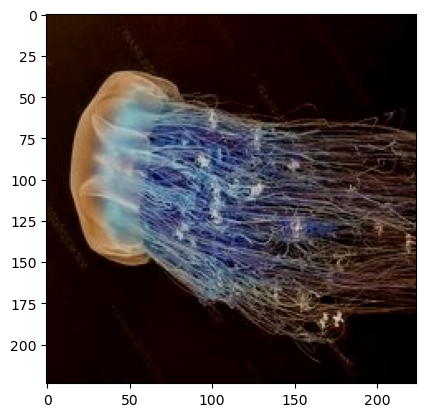

In [49]:
source = '/Users/acer/Downloads/archive/lions_mane_jellyfish/aug-9-10.jpg'
classification(source)